# Import

In [1]:
import numpy as np

In [1]:
import torch 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from torch.cuda.amp import autocast
from torch.cuda import amp
from torch.optim import lr_scheduler
import time
import gc
import copy
from collections import defaultdict


from dotenv import load_dotenv
import matplotlib.pyplot as plt
import albumentations as A
from pathlib import Path
from PIL import Image


from albumentations.pytorch import ToTensorV2
pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
import segmentation_models_pytorch as smp

Looking in links: /kaggle/input/pip-download-for-segmentation-models-pytorch
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/segmentation_models_pytorch-0.3.3-py3-none-any.whl
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/pretrainedmodels-0.7.4.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/efficientnet_pytorch-0.7.1.tar.gz (from segmentation-models-pytorch)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/timm-0.9.2-py3-none-any.whl (from segmentation-models-pytorch)
Processing /kaggle/input/pip-download-for-segmentation-models-pytorch/munch-4.0.0-py2.py3-none-any.whl (from pretrainedmodels==0.7.4->segmentation-models-pytorch)
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e945f882d88404c11cadec3d8c12a62403cc4

# config

In [3]:
p_augm = 0.05 #0.5
#add rotate.  less p_augm
p_Rot = 0.3

class CFG:
    # ============== pred target =============
    target_size = 1

    # ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 5   #5 # 65
    # ============== training CFG =============
    image_size = 1024
    input_size= 1024
    

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_batch_size = 4
    n_accumulate  = max(1, 32 // train_batch_size )
    valid_batch_size = train_batch_size * 2

    epochs = 28
    lr = 3e-4
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1


    # ============== augmentation =============
    train_aug_list = [
        A.Rotate(limit=270, p= p_Rot),
        A.RandomScale(scale_limit=(0.8,1.25),interpolation=cv2.INTER_CUBIC,p=p_augm),
        A.RandomCrop(input_size, input_size,p=1),
        A.GaussNoise(var_limit=[10, 50]),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm,),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        A.ElasticTransform(alpha=100, sigma=10, alpha_affine=4, p=p_augm ),
        ToTensorV2(transpose_mask=True),
    ]
    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug = A.Compose(valid_aug_list)




In [4]:
def subset_df(train_df, base_dir, im_dir='kidney_1_dense',lb_dir='kidney_1_dense'):


    micro_df = train_df[train_df['id'].str.startswith(lb_dir)]
    print(base_dir / im_dir / 'images' )
    micro_df['images'] = micro_df['img_name'].map(lambda x: base_dir / im_dir / 'images' / f'{x}.tif')
    micro_df['labels'] = micro_df['img_name'].map(lambda x: base_dir / lb_dir / 'labels' / f'{x}.tif')
    micro_df['images_width'] = micro_df['images'].map(lambda x: Image.open(x).size[0])
    micro_df['images_height'] = micro_df['images'].map(lambda x: Image.open(x).size[1])

    micro_df['labels_width'] = micro_df['labels'].map(lambda x: Image.open(x).size[0])
    micro_df['labels_height'] = micro_df['labels'].map(lambda x: Image.open(x).size[1])

    return micro_df

In [5]:
path_to_train_df = '/kaggle/input/blood-vessel-segmentation/train_rles.csv'
BASE_DIR = Path("/kaggle/input/blood-vessel-segmentation/")

In [6]:
train_df = pd.read_csv(BASE_DIR / 'train_rles.csv')

In [7]:
train_df['data_set'] = train_df['id'].map(lambda x: x[:-5] )
train_df['kidney'] = train_df['id'].map(lambda x: '_'.join(x.split('_')[:2] ))
train_df['type'] = train_df['id'].map(lambda x: x.split('_')[2] if '_'.join(x.split('_')[:2]) != 'kidney_2' else '')
train_df['img_name'] = train_df['id'].map(lambda x: x.split('_')[-1] )
train_df['mask_is_empty'] = train_df['rle'] == '1 0'

In [ ]:
kidney_1_dense = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_1_dense',lb_dir='kidney_1_dense')
##kidney_1_voi = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_1_voi',lb_dir='kidney_1_voi')
#kidney_2 = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_2',lb_dir='kidney_2')
kidney_3_sparse = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_3_sparse',lb_dir='kidney_3_sparse')
kidney_3_dense = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_3_sparse',lb_dir='kidney_3_dense')

/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images


In [ ]:
del(train_df)
#train_df = pd.concat([kidney_1_dense, kidney_1_voi, kidney_2, kidney_3_sparse, kidney_3_dense], axis = 0)
train_df = pd.concat([kidney_1_dense, kidney_3_sparse, kidney_3_dense], axis = 0)

In [ ]:
def resize_to_size( img, image_size = CFG.image_size):
        '''
        resizes the image if its side is smaller than image_size
        padding is the average between the maximum and minimum pixels on the border
        '''
        if image_size > img.shape[0]:
            start = ( image_size - img.shape[0])//2
            val1 = (min(img[0,:]).item() + max(img[0,:]).item()) // 2
            val2 = (min(img[img.shape[0] - 1,:]).item() + max(img[img.shape[0] - 1,:]).item()) // 2
            print(val1, val2)
            top= torch.full((start,img.shape[1]),val1)
            botton = torch.full((start,img.shape[1]),val2)
            #print(border.shape)
            return torch.cat((top, img, botton), axis = 0)
        elif image_size > img.shape[1]:
            start = ( image_size - img.shape[1])//2
            val1 = (min(img[:, 0]).item() + max(img[:, 0]).item()) // 2
            val2 = (min(img[:, img.shape[1] - 1]).item() + max(img[:, img.shape[1] - 1]).item()) // 2
            left= torch.full((img.shape[0], start),val1)
            right = torch.full((img.shape[0], start),val2)
            return torch.cat((left, img, right), axis = 1)
        else:
            return img

In [ ]:
class Data_loader(Dataset):
    '''
        Сlass for quickly loading a dataset from a folder and converting it to tenzor
        Args:
          df: (pd.DataFrame) - dataframe with paths to images
          is_label: bool - upload an image or segmentation mask
    '''

    def __init__(self,df, is_label = False, image_size = CFG.image_size):
        self.df = df
        self.image_size = image_size

        self.is_label=is_label

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,index):
        read_image = 'images'
        if self.is_label:
            read_image = 'labels'
        path_img = str(self.df[read_image].iloc[index])
        img = cv2.imread(path_img,cv2.IMREAD_GRAYSCALE)
        img=torch.from_numpy(img.copy())
        img = resize_to_size(img, self.image_size) if self.image_size  else  img
        
        if self.is_label:
            img=(img!=0).to(torch.uint8)*255
        else:
            img=img.to(torch.uint8)
        
        return img

In [14]:
zz = Data_loader(train_df[train_df['data_set'] == 	'kidney_1_dense'],False, 0)
yy = Data_loader(train_df[train_df['data_set'] == 	'kidney_1_dense'],True, 0)

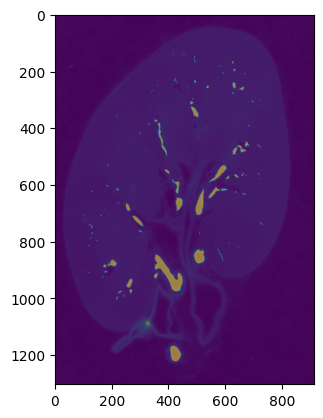

In [15]:
plt.imshow(yy[1100])
plt.imshow(zz[1100],alpha = 0.5)


In [16]:
del(yy)

In [17]:
del(zz)

In [ ]:
def min_max_normalization(x:torch.Tensor)->torch.Tensor:
    """min max normalization by last dimension
    input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_- min_+1e-9)
    return x.reshape(shape)

In [ ]:
def load_data(df ,is_label=False, chopping_percentile = CFG.chopping_percentile):
    '''function to load data into an array'''
    data_loader_data=Data_loader(df,is_label)
    data_loader=DataLoader(data_loader_data, batch_size=8, num_workers=2)
    data=[]
    del(data_loader_data)
    for x in tqdm(data_loader):
        data.append(x)
    x=torch.cat(data,dim=0)
    del data
    del(data_loader)
    if not is_label:
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * chopping_percentile)
        TH:int = np.partition(TH, index)[index]
        x[x>TH]=int(TH)
        ########################################################################
        TH=x.reshape(-1).numpy()
        index = -int(len(TH) * chopping_percentile)
        TH:int = np.partition(TH, -index)[-index]
        x[x<TH]=int(TH)
        x=(min_max_normalization(x.to(torch.float16)[None])[0]*255).to(torch.uint8)
    return x

In [ ]:
train_x=[]
train_y=[]

x = load_data(train_df[train_df['data_set'] == 'kidney_1_dense'],is_label=False)
train_x.append(x)
train_x.append(x.permute(1,2,0))
train_x.append(x.permute(2,0,1))
del(x)

y=load_data(train_df[train_df['data_set'] == 'kidney_1_dense'],is_label=True)
train_y.append(y)
train_y.append(y.permute(1,2,0))
train_y.append(y.permute(2,0,1))
del(y)

In [ ]:
val_x = load_data(train_df[train_df['data_set'] == 'kidney_3_sparse'],is_label=False)
val_y = load_data(train_df[train_df['data_set'] == 'kidney_3_dense'],is_label=True)

In [25]:
class Kaggld_Dataset(Dataset):
    def __init__(self,x,y,image_size=CFG.image_size, in_chans=CFG.in_chans, arg=False):
        super(Dataset,self).__init__()
        self.x=x#list[(C,H,W),...]
        self.y=y#list[(C,H,W),...]
        self.image_size=image_size
        self.in_chans=in_chans
        self.arg = arg
        if arg:
            self.transform=CFG.train_aug
        else: 
            self.transform=CFG.valid_aug
        

    def __len__(self) -> int:
        return sum([y.shape[0]-self.in_chans for y in self.y])

    def __getitem__(self,index):
        i = 0
        # selecting a dataset section
        for x in self.x:
            if index > x.shape[0]-self.in_chans:
                index -= x.shape[0]-self.in_chans
                i += 1
            else:
                break
        #print(f'component {i}')
        x=self.x[i]
        y=self.y[i]
        #print(print (f'x.shape[1] ={x.shape[1]}    x.shape[2]={x.shape[2]}'))
        x_index= (x.shape[1]-self.image_size)//2
        y_index= (x.shape[2]-self.image_size)//2
        #print(x_index, x_index)
        x=x[index:index+self.in_chans   ,  :,:]# x_index:x_index+self.image_size,   y_index:y_index+self.image_size]
        # i+2
        y=y[index+self.in_chans//2   , :,:]#    x_index:x_index+self.image_size,   y_index:y_index+self.image_size]
        #x = torch.from_numpy(x)
        #y = torch.from_numpy(x)
        if self.transform:
            data = self.transform(image=x.numpy().transpose(1,2,0), mask=y.numpy()) #C H W
            x = data['image']
            y = data['mask']>=127

        if self.arg:
            i=np.random.randint(4)
            x=x.rot90(i,dims=(1,2))
            y=y.rot90(i,dims=(0,1))
            for i in range(3):
                if np.random.randint(2):
                    x=x.flip(dims=(i,))
                    if i>=1: # if i == 0: we swaps pictures in the channels
                        y=y.flip(dims=(i-1,))
        return x, y

In [74]:
def norm_with_clip(x:torch.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

In [82]:
def dice_coef( y_pred,y_true, thr=0.5, dim=(2,3), epsilon=0.0001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef( y_pred,y_true, thr=0.5, dim=(2,3), epsilon=0.0001):
    y_true = y_true.unsqueeze(1).to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [85]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, epoch):
    model.train()
    scaler = amp.GradScaler()
    train_loss = 0.0
    dataset_size = 0
    train_scores = []
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    optimizer.zero_grad()
    for step, (x, y) in pbar:
        x = x.to(CFG.device, dtype=torch.float32)
        y  = y.to(CFG.device, dtype=torch.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        batch_size = x.size(0)
        dataset_size += batch_size

        with amp.autocast(enabled=True):
            y_pred = model(x)
            loss   = loss_fn(y_pred, y)
            loss   = loss / CFG.n_accumulate

        #optimizer.zero_grad()
        scaler.scale(loss).backward() #loss.backward()  # backward-pass
        
        if ((batch_idx + 1) % CFG.accum_iter == 0) or (batch_idx + 1 == len(data_loader)):
            scaler.step(optimizer) #optimizer.step()  # update weights
            scaler.update()
            optimizer.zero_grad()

        train_loss  += loss.item()  * batch_size

        epoch_loss = train_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        
        y_pred = nn.Sigmoid()(y_pred)
        train_dice = dice_coef(y_pred.detach(), y ).cpu().detach().numpy()
        train_jaccard = iou_coef(y_pred.detach(), y ).cpu().detach().numpy()
        train_scores.append([train_dice, train_jaccard])

        pbar.set_postfix( epoch=f'{epoch}',
                          train_loss=f'{epoch_loss:0.4f}',
                          #train_dice = f'{train_dice:0.4f}',
                          #train_jaccard = f'{train_jaccard:0.4f}',
                          lr=f'{current_lr:0.5f}',
                          gpu_mem=f'{mem:0.2f} GB')


    train_scores  = np.mean(train_scores, axis=0)

    del images
    del masks
    del y_pred
    gc.collect()
    torch.cuda.empty_cache()
    return epoch_loss, train_scores

In [86]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, loss_fn,  epoch,):
 #(model, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images  = images.to(CFG.device, dtype=torch.float32)
        masks   = masks.to(CFG.device, dtype=torch.float32)

        batch_size = images.size(0)

        y_pred  = model(images)
        loss    = loss_fn(y_pred, masks)

        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef( y_pred, masks).cpu().detach().numpy()
        val_jaccard = iou_coef( y_pred, masks).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0

        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, val_scores

In [87]:
def run_training(model, optimizer, loss_fn, scheduler, device, num_epochs, train_loader, valid_loader, model_name = 'unet'):
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss      = np.inf
    best_epoch     = -1
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss, train_scores = train_one_epoch(model=model,
                                                         dataloader=train_loader, loss_fn=loss_fn, optimizer=optimizer, epoch=epoch)



        val_loss, val_scores = valid_one_epoch(model=model, dataloader=valid_loader, loss_fn=loss_fn,  epoch=epoch, device = device)
        if scheduler:
            scheduler.step(val_loss)
        train_dice, train_jaccard = train_scores
        val_dice, val_jaccard = val_scores

        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Train Dice'].append(train_dice)
        history['Train Jaccard'].append(train_jaccard)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        print(f'Train Dice: {train_dice:0.4f} | Train Jaccard: {train_jaccard:0.4f}')
        print(f'Train Loss: {train_loss}')
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        print(f'Valid Loss: {val_loss}')

        # deep copy the model
        if val_loss <= best_loss:
            print(f"{c_}Valid loss Improved ({best_loss} ---> {val_loss})")
            best_dice    = val_dice
            est_jaccard = val_jaccard
            best_loss = val_loss
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            save_model(model=model, optimizer= None, epoch=epoch, model_name = model_name + ' ' + str(epoch),  lr_scheduler=None)
            print(f"Model Saved{sr_}")
        print(); print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_loss))

    
    del(model)
    return history

In [88]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [34]:
def build_model(backbone = 'se_resnext50_32x4d', backbone_weights = 'imagenet', 
                num_classes = CFG.target_size,
                device = CFG.device):
    model = smp.Unet(encoder_name=CFG.backbone, 
                     in_channels=CFG.in_chans, 
                     encoder_weights=backbone_weights, 
                     classes= num_classes, 
                     activation=None )
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    return model.to(device)

In [26]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

train_dataset=Kaggld_Dataset(train_x,train_y,arg=True)
val_dataset=Kaggld_Dataset([val_x],[val_y])


In [32]:
train_loader= DataLoader(train_dataset, batch_size=CFG.train_batch_size ,num_workers=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.valid_batch_size, num_workers=2, shuffle=False, pin_memory=True)

In [36]:
model = build_model(backbone_weights = None)
model=DataParallel(model)

In [58]:
loss_fn =DiceLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=CFG.lr)
scaler=torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, patience=3,threshold = 1e-3, verbose=True, factor=0.8, mode = 'min')


In [ ]:
history = run_training(model=model,
             optimizer=optimizer,
             loss_fn = loss_fn,
             scheduler = scheduler,
             device = CFG.device,
             num_epochs = 1,
             train_loader = train_loader,
             valid_loader=val_loader,
             model_name = 'first_baseline_fp16_unet')

Epoch 1/1

/opt/conda/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
Train :   0%|          | 0/1148 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
train_dataset=Kaggld_Dataset(x=train_x,
                             y=train_y, 
                             arg=True, transform= CFG.train_aug )
train_loader = DataLoader(train_dataset,
           batch_size=CFG.train_batch_size ,
           num_workers=2, shuffle=True, pin_memory=True)

In [ ]:
a, b = next(iter(train_loader))

In [ ]:
a.shape

In [ ]:
train

In [ ]:
z = train_dataset[1000]

In [ ]:
z[0]

In [ ]:
#(C,H,W)

#aug
train_x.append(x.permute(1,2,0))
train_y.append(y.permute(1,2,0))
train_x.append(x.permute(2,0,1))
train_y.append(y.permute(2,0,1))
del(x)
del(y)

In [ ]:
x=(min_max_normalization(x.to(torch.float16)[None])[0]*255).to(torch.uint8)

In [ ]:
plt.imshow(x[1500])

In [ ]:
x[1500]

# Model

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image):
        output = self.model(image)
        return output[:,0]
    
    def forward(self,x:tc.Tensor):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
        x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
        x=tc.cat(x,dim=0)
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        x=x.reshape(4,shape[0],*shape[2:])
        x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

# Size

In [ ]:
def to_1024(img , image_size = 1024):
    if image_size > img.shape[1]:
       img = np.rot90(img)
       start1 = (CFG.image_size - img.shape[0])//2 
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
    else :
       img_result = img
    return img_result

def to_1024_no_rot(img, image_size = 1024):
    if image_size > img.shape[0]:  
       start1 = ( image_size - img.shape[0])//2
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
    else: 
       img_result = img
    return img_result

def to_1024_1024(img  , image_size = 1024 ):
     img_result = to_1024(img, image_size )
     return img_result
    
def to_original ( im_after, img, image_size = 1024 ):
    top_ = 0
    left_ = 0
    if (im_after.shape[0] > img.shape[0]):
             top_  = ( image_size - img.shape[0])//2 
    if    (im_after.shape[1] > img.shape[1]) :
             left_  = ( image_size - img.shape[1])//2  
    if (top_>0)or (left_>0) :
             img_result = im_after[top_  : img.shape[0] + top_,   left_: img.shape[1] + left_ ]
    else:
             img_result = im_after
    return img_result  

# Functions

In [ ]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        img = to_1024_1024(img , image_size = CFG.image_size )
        
        img=tc.from_numpy(img.copy())
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x in tqdm(data_loader):
        data.append(x)
    x=tc.cat(data,dim=0)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [ ]:
model=build_model()
model.load_state_dict(tc.load(CFG.model_path[ model_path_i ],"cpu"))
model.eval()
model=DataParallel(model)

In [ ]:
def get_output(debug=False):
    outputs=[]
    
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/train/kidney_2"]
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[]]
    for path in [ paths[CFG.path_submition] ]:
        x=load_data(path,"/images/")
        labels=tc.zeros_like(x,dtype=tc.uint8)
        mark=Pipeline_Dataset(x,path).get_marks()
        
        
        for axis in [0,1,2]:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=1)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])

                y_preds = model.forward(tc.cat(chip)).to(device=0)

                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
                
                labels_[index]+=(mask_pred[0]*255 /3 ).to(tc.uint8).cpu()
                if debug:
                    debug_count+=1
                    plt.subplot(121)
                    plt.imshow(img[0,CFG.in_chans//2].cpu().detach().numpy())
                    plt.subplot(122)
                    plt.imshow(mask_pred[0].cpu().detach().numpy())
                    plt.show()
                    if debug_count>3:
                        break
        outputs[0].append(labels)
        outputs[1].extend(mark)
    return outputs

In [ ]:
is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3
#is_submit=True
output,ids=get_output(not is_submit)


####################################
TH=[x.flatten().numpy() for x in output]
TH=np.concatenate(TH)
index = -int(len(TH) * CFG.th_percentile)
TH:int = np.partition(TH, index)[index]
print(TH)

img=cv2.imread("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif",cv2.IMREAD_GRAYSCALE)

####################################
submission_df=[]
debug_count=0
for index in range(len(ids)):
    id=ids[index]
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]>TH).numpy()
    
    mask_pred2 = to_original ( mask_pred, img, image_size = 1024 )
    mask_pred =  mask_pred2.copy()
    
    ####################################
    if not is_submit:
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        debug_count+=1
        if debug_count>6:
            break
        
    rle = rle_encode(mask_pred)
    
    submission_df.append(
        pd.DataFrame(data={
            'id'  : id,
            'rle' : rle,
        },index=[0])
    )

submission_df =pd.concat(submission_df)
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)